# Exercise 6: Analysis of real data  (score 30 points)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
import os
from common import *
import cv2
#from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler


print(f"Root directory: {os.getcwd()}")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

%matplotlib inline 

Root directory: c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project1\FYS-STK4155-Prj1_report\code


# Global variables

In [2]:
np.random.seed(SEED_VALUE) # Random seed to guarantee reproducibility
# Paths
#INPUT_DATA = "data/input_data/"  # Path for input data
#REPORT_DATA = "data/report_data/" # Path for data ment for the report
#REPORT_FIGURES = "figures/" # Path for figures ment for the report
# Setting for range of degrees
from_degree = 0
to_degree = 14
degrees = np.arange(from_degree,to_degree)
degree = 5
# Setting for logspace range of lambdas 
from_lambda = -7 #
to_lambda = 3 #
nLambdas = 10
lambdas = np.logspace(from_lambda, to_lambda, nLambdas)
# Rescale settings
rescale_factor = 0.5

# Reading and plotting terrain data

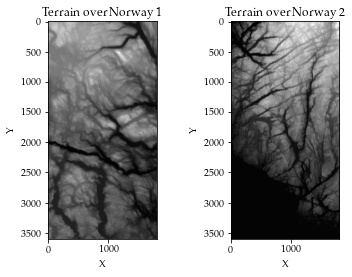

In [3]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 = imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1, cmap='gray')
ax2.title.set_text("Terrain over Norway 2")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2, cmap='gray')
plt.savefig(f"{REPORT_FIGURES}terrain_data.pdf")

# 3D plot of the whole Terrain image

In [4]:
# Make data for terrain1
z1 = np.array(terrain1)
scaler = MinMaxScaler()
scaler.fit(z1)
z1_scaled = scaler.transform(z1)
#y1 = np.linspace(0,1,z1.shape[0])
#x1 = np.linspace(0,1,z1.shape[1])
y1 = np.arange(0, z1.shape[0])
x1 = np.arange(0, z1.shape[1])
x1_m, y1_m = np.meshgrid(x1,y1)

# Make data for terrain2
z2 = np.array(terrain2)
scaler = MinMaxScaler()
scaler.fit(z2)
z2_scaled = scaler.transform(z2)
#y2 = np.linspace(0,1,z2.shape[0])
#x2 = np.linspace(0,1,z2.shape[1])
y2 = np.arange(0, z2.shape[0])
x2 = np.arange(0, z2.shape[1])
x2_m, y2_m = np.meshgrid(x2,y2)

%matplotlib
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.title.set_text("Terrain1 plot")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
ax1.plot_surface(x1_m, y1_m, z1, cmap=cm.coolwarm, linewidth = 0, antialiased=False)

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.title.set_text("Terrain2 plot")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("z")
ax2.plot_surface(x2_m, y2_m, z2, cmap=cm.coolwarm, linewidth = 0, antialiased=False)


Using matplotlib backend: Qt5Agg


# Slicing out terrain data of interest

In [5]:
x_from = 801
x_to = terrain1.shape[1]
y_from = 0
y_to = x_to-x_from
img1 = terrain1[y_from:y_to, x_from:x_to]; print(img1.shape); print(img1.flatten().shape)
img2 = terrain2[y_from:y_to, x_from:x_to]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(img1, cmap='gray')
ax2.title.set_text("Terrain over Norway 2")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(img2, cmap='gray')


(1000, 1000)
(1000000,)


# Creating dataset

In [6]:
# Using data from img1 or img2
img = img1 #img2
z = np.array(img); print(z.shape)
y = np.arange(0, z.shape[0])
x = np.arange(0, z.shape[1])
x_m, y_m = np.meshgrid(x,y)

(1000, 1000)


# 3D plot of our data

In [7]:
fig = plt.figure() 
ax1 = fig.add_subplot(1,2,1, projection='3d') 
ax1.title.set_text("Terrain data")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("z")
ax1.view_init(elev=37., azim=-7.0)
surf1 = ax1.plot_surface(x_m,y_m,z, cmap=cm.coolwarm, linewidth = 0, antialiased=False)

# 1. Preprocessing and transformation
Least Square regression is not designed to tackle images directly. Thus, we must first transform the terrain data by slicing it into several bits and pieces. 

In [8]:
# Preprocess
# Flattening the 2D images grid data
#x_flat = x.ravel()
#y_flat = y.ravel()

# 2. Constructing input data for least square regression
We construct the data for least square regression based on preprocessed data. We also set up variables that will be used throughout the exercise.

In [9]:
degree = 2
X = create_X(x_m, y_m, degree)
z = z.ravel()
print(X.shape)
print(z.shape)

(1000000, 6)
(1000000,)


In [17]:
degrees = 8
z_train_OLS = pd.DataFrame()
z_hat_train_OLS = pd.DataFrame()
z_test_OLS = pd.DataFrame()
z_hat_test_OLS = pd.DataFrame()
coeffs_df = pd.DataFrame()

for degree in range(1, degrees+1):
    X = create_X(x_m, y_m, degree) # Design Matrix
    
    # Scaling data and splitting it into training and test sets
    #X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False)
    X_train, X_test, z_train, z_test = prepare_data(X, z, test_size=0.2, shuffle=True, scale_X=False, scale_t=False, random_state=4155)
    
    # Model construction, fitting, and predictions
    model = OLS() # The model
    z_hat_train = model.fit(X_train, z_train, SVDfit=False) # Fitting the model and predict on training data
    z_hat_test = model.predict(X_test) # predict on test data
    
    # Evaluatation metrics
    MSE_score_train = MSE(z_train, z_hat_train)
    R2_score_train = R2(z_train, z_hat_train)
    MSE_score_test = MSE(z_test, z_hat_test)
    R2_score_test = R2(z_test, z_hat_test)
    
    # Estimated standard error for the beta coefficients
    N, P = X_train.shape
    #var_hat = (1/(N-P-1)) * np.sum((z_train - z_hat_train)**2)
    var_hat = (1/N) * np.sum((z_train - z_hat_train)**2) # Estimated variance
    invXTX_diag = np.diag(np.linalg.inv(X_train.T @ X_train)) 
    SE_betas = np.sqrt(var_hat * invXTX_diag) # Standard Error

    # Calculating 95% confidence intervall
    betas = model.get_all_betas()
    CI_lower_all_betas = betas - (1.96 * SE_betas)
    CI_upper_all_betas = betas + (1.96 * SE_betas)
    CL = np.zeros((CI_upper_all_betas.shape[0],2))
    CL[:,0] = CI_lower_all_betas
    CL[:,1] = CI_upper_all_betas
    
    # Printing results
    print(f"Degree: {degree}")
    print(f"Train data - Mean Square Error: {MSE_score_train}")
    print(f"Train data - R2 score: {R2_score_train}")
    print(f"Test data - Mean Square Error: {MSE_score_test}")
    print(f"Test data - R2 score: {R2_score_test}")
    print(f"Estimated variance: {var_hat}")
    print(f"Beta - values{betas}")
    print(f"Beta - Std Errors: {SE_betas}")
    print(f"Beta - Confidence Interval (CI):\n{CL}\n")

    # Constructing dataframe for beta coefficients
    degs = np.zeros(betas.shape[0]); degs.fill(degree)
    df = pd.DataFrame.from_dict({"degree" :degs,
                                 "coeff name": [f"b{i}" for i in range(1,betas.shape[0]+1)],
                                 "coeff value": np.round(betas, decimals=4),
                                 "Std Error": np.round(SE_betas, decimals=4),
                                 "CI lower":np.round(CI_lower_all_betas, decimals=4), 
                                 "CI_upper":np.round(CI_upper_all_betas, decimals=4)},
                                 orient='index').T
    coeffs_df = pd.concat([coeffs_df,df], axis=0)
        
    # Filling up dataframes for train and test evaluation
    z_train_OLS[degree] = z_train.flatten() 
    z_hat_train_OLS[degree] = z_hat_train.flatten()
    z_test_OLS[degree] = z_test.flatten()
    z_hat_test_OLS[degree] = z_hat_test.flatten()


# MSE calculations for all lambda values
mse_scores_train = ((z_train_OLS - z_hat_train_OLS) ** 2).mean()
mse_scores_test = ((z_test_OLS - z_hat_test_OLS) ** 2).mean()
# R2 calculations for all lambda values
R2_scores_train = 1 - ((z_train_OLS - z_hat_train_OLS) ** 2).sum() / ((z_train_OLS - z_train_OLS.mean())**2).sum() 
R2_scores_test = 1 - ((z_test_OLS - z_hat_test_OLS) ** 2).sum() / ((z_test_OLS - z_test_OLS.mean())**2).sum()


Degree: 1
Train data - Mean Square Error: 57656.04528093527
Train data - R2 score: 0.2829014326030197
Test data - Mean Square Error: 57576.959418162296
Test data - R2 score: 0.281196144387863
Estimated variance: 57656.04528093527
Beta - values[ 1.06823021e+03 -5.09562213e-01  1.14566829e-01]
Beta - Std Errors: [0.70970852 0.00092978 0.00093006]
Beta - Confidence Interval (CI):
[[ 1.06683918e+03  1.06962124e+03]
 [-5.11384573e-01 -5.07739854e-01]
 [ 1.12743916e-01  1.16389742e-01]]

Degree: 2
Train data - Mean Square Error: 55914.76212850734
Train data - R2 score: 0.30455868724048707
Test data - Mean Square Error: 55819.9290116631
Test data - R2 score: 0.30313131156900786
Estimated variance: 55914.76212850734
Beta - values[ 1.06503085e+03 -7.50858438e-01  4.86647737e-01  1.30053368e-04
  2.23205836e-04 -4.84042270e-04]
Beta - Std Errors: [1.34496282e+00 3.98645448e-03 3.98814301e-03 3.54488796e-06
 3.17263075e-06 3.54733515e-06]
Beta - Confidence Interval (CI):
[[ 1.06239473e+03  1.0676

In [18]:
plt.plot(np.arange(1,degrees+1), mse_scores_test,"m", label='MSE_test')
plt.plot(np.arange(1,degrees+1), mse_scores_train,"c", label='MSE_train')

plt.xlabel("Model complexity / Polynomial Degree")
plt.ylabel("Prediction Error")

plt.grid(True)
plt.legend()
#plt.savefig(f"{REPORT_FIGURES}franke_function_OLS_evaluate_fit.pdf")
plt.show()